In [1]:
import dask
import dask.dataframe as dd
import dask_geopandas as dg
import datetime as dt
import geopandas as gpd
import glob
import os
import pandas as pd
import sys

from shared_utils import utils
#from utilities import catalog_filepath, GCS_FILE_PATH
from update_vars import analysis_date

/opt/conda/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
DASK_GCS = "gs://calitp-analytics-data/data-analyses/dask_test/"
HQTA_GCS = "gs://calitp-analytics-data/data-analyses/high_quality_transit_areas/"

PAIRWISE_FILE = f"{DASK_GCS}intermediate/pairwise.parquet"
SUBSET_CORRIDORS = f"{DASK_GCS}intermediate/subset_corridors.parquet"

In [3]:
intersecting_pairs = pd.read_parquet(PAIRWISE_FILE)
corridors = gpd.read_parquet(SUBSET_CORRIDORS)

In [63]:
from update_vars import COMPILED_CACHED_VIEWS


In [ ]:
def buffer_around_segments_that_intersect(gdf: dg.GeoDataFrame, 
                                          buffer_size: int = 50) -> dg.GeoDataFrame:
    EPSG_CODE = corridors.crs.to_epsg()
    
    MAJOR_OPERATORS = corridors.calitp_itp_id.unique()
    
    corridors_poly = corridors.assign(
        geometry = corridors.geometry.buffer(buffer_size)
    )
    
    all_stops = gpd.read_parquet(
        f"{COMPILED_CACHED_VIEWS}stops_{analysis_date}.parquet"
    ).to_crs(f"EPSG: {EPSG_CODE}")
    
    # Filter stops down to the ones that also appear for operators in corridors
    all_stops = all_stops[all_stops.calitp_itp_id.isin(MAJOR_OPERATORS)]
    
    stops_in_intersections = dg.sjoin(all_stops, 
             corridors_poly, 
             how = "inner",
             predicate = "intersects",
            )
    
    return stops_in_intersections
    

In [4]:
intersecting_pairs.shape, corridors.shape

((251758, 4), (16115, 13))

In [5]:
def find_corresponding_pairs(gdf: gpd.GeoDataFrame, 
                             pairs_table: pd.DataFrame, 
                             itp_id: int)-> gpd.GeoDataFrame:
    
    operator_segments = (gdf[gdf.calitp_itp_id==itp_id]
                         .hqta_segment_id.unique()#.tolist() 
                        )
        
    intersecting_routes = (pairs_table[
        pairs_table.hqta_segment_id.isin(operator_segments)]
        .intersect_hqta_segment_id
        .unique().tolist()
    )
    
    corresponding_pairs = (gdf[gdf.hqta_segment_id.isin(intersecting_routes)]
                       [["hqta_segment_id", "geometry"]]
                       .drop_duplicates()
                       .reset_index(drop=True)
                      )
    
    return corresponding_pairs

In [ ]:
def clip(operator_df: dg.GeoDataFrame, 
         intersecting_pairs: gpd.GeoDataFrame, 
        ) -> dg.GeoDataFrame:
    
    operator_routes = operator_df.route_identifier.unique()
    
    results = []
    
    for i in operator_routes:
        clipped = dg.clip(
            operator_df[operator_df.route_identifier==i],
            intersecting_pairs[intersecting_pairs.route_identifier != i], 
            keep_geom_type = True
        )
        results.append(clipped)
    
    intersections = dd.multi.concat(results, axis=0).drop_duplicates()

    return intersections

In [6]:
itp_id = 182

metro = corridors[corridors.calitp_itp_id==itp_id]

test_route = 3588563102 # 720
test_route

3588563102

In [ ]:
#test = corridors.set_index("calitp_itp_id").loc[182]

In [7]:
metro720_segments = metro[metro.route_identifier==test_route].hqta_segment_id.unique()

In [20]:
metro_pairs = intersecting_pairs[
    intersecting_pairs.hqta_segment_id.isin(metro720_segments)]

In [25]:
# Take a look at what routes intersect with Metro's 720
cols = ["calitp_itp_id", "route_id", "hqta_segment_id", 
        "route_identifier", "geometry"]

# Full info of metro_pairs displayed
corridors[corridors.hqta_segment_id.isin(metro_pairs.intersect_hqta_segment_id)].head()

,calitp_itp_id,route_id,route_identifier,segment_sequence,geometry,hqta_segment_id,route_direction,stop_id,am_max_trips,pm_max_trips,hq_transit_corr,hqta_type,route_type
1569,16,786,1981946657,211,"POLYGON ((142685.672 -438959.427, 142704.766 -...",183781819,north-south,28,8,8,True,hqta_transit_corr,3
1571,16,786,1981946657,99,"POLYGON ((142685.672 -438959.427, 142743.296 -...",379764064,north-south,28,8,8,True,hqta_transit_corr,3
1578,16,786,1981946657,103,"POLYGON ((147264.229 -437089.491, 146760.647 -...",4289177487,north-south,553,5,5,True,hqta_transit_corr,3
2191,87,6,2323929239,8,"POLYGON ((143010.302 -438780.191, 143015.656 -...",2497828268,north-south,710,8,7,True,hqta_transit_corr,3
2207,87,6R,965107178,11,"POLYGON ((143010.302 -438780.191, 143015.656 -...",1729174238,north-south,710,8,7,True,hqta_transit_corr,3


In [26]:
# Pick one segment along 720 to look at
metro_segment = 49694670

In [35]:
metro[metro.hqta_segment_id==metro_segment].explore("route_id")

In [31]:
intersect_with_segment = metro_pairs[metro_pairs.hqta_segment_id==metro_segment]
intersect_with_segment.head()

,hqta_segment_id,route_direction,intersect_hqta_segment_id,intersect_route_direction
58,49694670,east-west,1420142734,north-south
64,49694670,east-west,2105576100,north-south
76,49694670,east-west,1282211220,north-south
84,49694670,east-west,716729021,north-south
89,49694670,east-west,3580210222,north-south


In [34]:
corridors[corridors.hqta_segment_id.isin(
    intersect_with_segment.intersect_hqta_segment_id)].explore("route_id")

Why still clipping needed?

All the pairwise combos that show up, those are where the intersections occur, and those segments can be selected, draw buffer on, and find stops near there.

In [37]:
one_route = metro[metro.route_identifier==test_route]

In [40]:
intersecting_pairs_for_one_route = intersecting_pairs[
    intersecting_pairs.hqta_segment_id.isin(one_route.hqta_segment_id.unique())
]

In [46]:
these_segments_intersect_with_720 = corridors[
    corridors.hqta_segment_id.isin(
        intersecting_pairs_for_one_route.intersect_hqta_segment_id.unique())][
    ["hqta_segment_id", "geometry"]]

<AxesSubplot:>

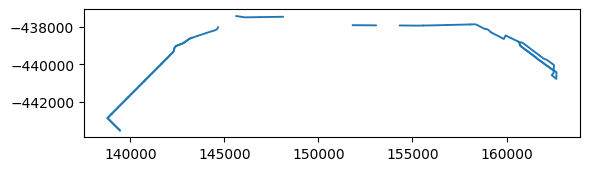

In [51]:
one_route.plot()

/opt/conda/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`


<AxesSubplot:>

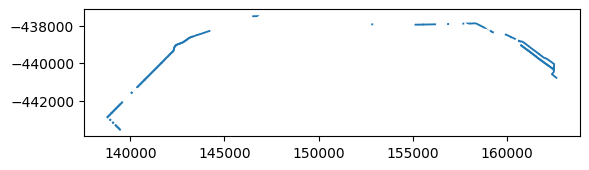

In [49]:
gpd.clip(one_route, 
         these_segments_intersect_with_720,
        keep_geom_type=True
        ).plot()

<AxesSubplot:>

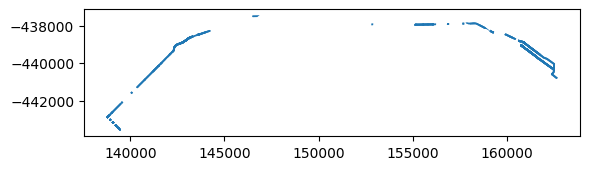

In [50]:
gpd.overlay(one_route, 
         these_segments_intersect_with_720,
         how="intersection", 
            keep_geom_type=False
        ).plot()

In [ ]:
import warnings
warnings.filterwarnings("ignore")

def intersections_for_operator(corridors, itp_id):
    operator_gdf = dg.from_geopandas(
        corridors[corridors.calitp_itp_id==itp_id], npartitions=1)
    
    pairs = find_corresponding_pairs(corridors, intersecting_pairs, itp_id)
        
    results = clip(operator_gdf, pairs)
    
    return results

In [ ]:
all_clipped = gpd.read_parquet(f"{HQTA_GCS}all_clipped.parquet")

metro_old = all_clipped[all_clipped.calitp_itp_id==182]
bbb_old = all_clipped[all_clipped.calitp_itp_id==300]

In [ ]:
metro = intersections_for_operator(corridors, 182).compute()

In [ ]:
metro.plot("segment_sequence")

In [ ]:
metro_old.plot("hqta_segment_id")

In [ ]:
bbb = intersections_for_operator(corridors, 300).compute()

In [ ]:
bbb.plot("segment_sequence")

In [ ]:
bbb_old.plot("hqta_segment_id")